# Yelp Restaurant Bankruptcy Analysis

---

# 1. Data Source

The dataset was collected from [Yelp Open Dataset](https://www.yelp.com/dataset) at two different periods: 6/2/2018 and 5/23/2019, with each dataset updated by Yelp on 8/22/2017 and 12/19/2018 respectively. Therefore, we shall assume that the information contained in both datasets differ by about 1 year. 

The summary of data preprocessing steps is shown below:

1. Drop all features of 2018 Business Data except `business_id` and `is_open_2018`.

2. Merge 2017 Business Data and 2018 Business Data by `business_id`.

3. Create `isBankrupt` label by checking if the business stays open or not in 2018 for all businesses that are open in 2017.

4. Narrow down the dataset to only the restaurants in Arizona, US.

5. Use `business_id` of these restaurants to downsize 2017 review data.

The analysis presented in this notebook will be done using preprocessed business and review data.


# 2. Data Cleaning

WARNING: This data cleaning section contain text cleaning, which may take about 2 hours to run.

In [1]:
# Run these commands in terminal to install required packages
if True:
    ! pip install -q uszipcode
    ! pip install -q spacy
    ! python -m spacy download -q en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [2]:
# Basic python packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Packages used for business features
from uszipcode import SearchEngine

In [4]:
# Packages used for review text features
import spacy
from gensim.utils import simple_preprocess

## 2.1 Clean Business Data

In [5]:
# Read business data
business = pd.read_csv('yelp_business.csv')
business.shape

(7183, 17)

In [6]:
# Look at first few rows of data
business.head()

address  \
0           719 E Thunderbird Rd   
1  777 E Thunderbird Rd, Ste 107   
2            1635 E Camelback Rd   
3                            NaN   
4     8140 N Hayden Rd, Ste H115   

                                          attributes             business_id  \
0  {'RestaurantsTableService': False, 'GoodForMea...  rDMptJYWtnMhpQu_rRXHng   
1  {'RestaurantsTableService': True, 'GoodForMeal...  1WBkAuQg81kokZIPMpn9Zg   
2  {'RestaurantsTableService': False, 'GoodForMea...  iPa__LOhse-hobC2Xmp-Kw   
3  {'BusinessAcceptsCreditCards': True, 'Business...  YhV93k9uiMdr3FlV4FHjwA   
4  {'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...  VdlPZg2NAu8t8GkdbPLecg   

                                          categories        city  \
0            ['Fast Food', 'Burgers', 'Restaurants']     Phoenix   
1                         ['Burgers', 'Restaurants']     Phoenix   
2            ['Restaurants', 'Burgers', 'Fast Food']     Phoenix   
3  ['Marketing', "Men's Clothing", 'Restaurants',...     Phoenix   
4  ['Restaurants', 'Gluten-Free', 'Indian', 'Seaf...  Scottsdale   

                                               hours  is_open_2017   latitude  \
0                                                 {}             1  33.607070   
1  {'Monday': '11:00-22:00', 'Tuesday': '11:00-22...             1  33.607310   
2  {'Monday': '5:00-23:00', 'Tuesday': '5:00-23:0...             1  33.508765   
3  {'Monday': '8:00-17:00', 'Tuesday': '8:00-17:0...             1  33.449967   
4  {'Tuesday': '17:00-22:00', 'Friday': '17:00-22...             1  33.555212   

    longitude                          name  neighborhood  postal_code  \
0 -112.064382                    McDonald's           NaN      85022.0   
1 -112.063404  Charr An American Burger Bar           NaN      85022.0   
2 -112.046240                    McDonald's           NaN      85016.0   
3 -112.070223               Caviness Studio           NaN      85001.0   
4 -111.900456  Tandoori Times Indian Bistro           NaN      85258.0   

   review_count  stars state  is_open_2018  isBankrupt  
0            10    1.0    AZ             1           0  
1           232    3.0    AZ             1           0  
2            34    3.0    AZ             1           0  
3             4    5.0    AZ             1           0  
4           263    3.5    AZ             1           0

In [7]:
# Make a copy of raw dataset
business_df = business.copy()

## 2.1.1 Check Duplicates

We checked that there are no duplicated records in our dataset.

In [8]:
# Check if there are duplicated records
business_df.equals(business_df.drop_duplicates())

True

## 2.1.2 Check Missing Values

In [9]:
# Convert empty dictionary and list into NAs
business_df = business_df.replace(['{}','[]'], np.nan)

In [10]:
# Compute number of missing values for each variable
business_df.isna().sum().sort_values(ascending=False)

neighborhood    7183
hours           1397
address           75
attributes        56
postal_code        8
is_open_2017       0
business_id        0
categories         0
city               0
isBankrupt         0
latitude           0
is_open_2018       0
name               0
review_count       0
stars              0
state              0
longitude          0
dtype: int64

To handle these missing data, We drop three columns (`neighborhood`, `hours`, `address`) that are not meaningful for our analysis and remove observations that contain missing `attributes` and `postal_code`. 

In [11]:
# Drop variables
business_df = business_df.drop(['neighborhood', 'hours', 'address'], axis=1)
business_df.shape

(7183, 14)

In [12]:
# Drop observations
business_df = business_df.dropna(axis=0, how='any')
business_df.shape

(7122, 14)

In [13]:
# Check if there is no more missing values
business_df.isna().sum()

attributes      0
business_id     0
categories      0
city            0
is_open_2017    0
latitude        0
longitude       0
name            0
postal_code     0
review_count    0
stars           0
state           0
is_open_2018    0
isBankrupt      0
dtype: int64

## 2.1.3 Check Postal Codes

We have verified that all postal codes have the standard five-digit format.

In [14]:
# Check postal_code column type
business_df['postal_code'].dtypes

dtype('float64')

In [15]:
# Convert postal codes from float to int 
business_df['postal_code'] = business_df['postal_code'].astype(int)

In [16]:
# Check all unique postal codes
business_df['postal_code'].unique()

array([85022, 85016, 85001, 85258, 85035, 85204, 85051, 85029, 85013,
       85339, 85004, 85248, 85044, 85215, 85306, 85323, 85224, 85373,
       85381, 85286, 85032, 85255, 85262, 85201, 85019, 85340, 85335,
       85251, 85249, 85233, 85296, 85298, 85382, 85006, 85206, 85281,
       85392, 85053, 85210, 85282, 85054, 85338, 85308, 85050, 85304,
       85379, 85305, 85301, 85085, 85014, 85202, 85302, 85284, 85283,
       85331, 85012, 85254, 85297, 85351, 85388, 85226, 85042, 85383,
       85295, 85209, 85018, 85020, 85040, 85017, 85033, 85208, 85374,
       85207, 85023, 85234, 85086, 85008, 85009, 85303, 85048, 85024,
       85253, 85260, 85043, 85266, 85212, 85027, 85034, 85083, 85236,
       85015, 85021, 85003, 85345, 85041, 85378, 85375, 85268, 85310,
       85259, 85007, 85225, 85028, 85205, 85395, 85250, 85257, 85353,
       85377, 85037, 85256, 85213, 85203, 85307, 85031, 85363, 85287,
       85073, 85005, 85280, 85058, 85264, 85821, 85252, 85355, 84295,
       85734, 85064,

## 2.1.4 Check Cities

In [17]:
# Check all unique cities
business_df['city'].unique()

array(['Phoenix', 'Scottsdale', 'Mesa', 'Laveen', 'Chandler', 'Glendale',
       'Avondale', 'Sun City', 'Peoria', 'Litchfield Park', 'El Mirage',
       'Gilbert', 'Tempe', 'Goodyear', 'Surprise', 'Cave Creek', 'MESA',
       'Paradise Valley', 'Sun City West', 'Fountain Hills', 'Ahwatukee',
       'Tolleson', 'Carefree', 'Central City', 'Scottdale', 'Sun Lakes',
       'Youngtown', 'Higley', 'Central City Village', 'Guadalupe',
       'Mesa AZ', 'Fort McDowell', 'Anthem', 'Waddell', 'Laveen Village',
       'Phoenix Valley', 'Glendale Az', 'Schottsdale', 'Phx'],
      dtype=object)

We found several city names that refer to the same cities but with different names. (E.g. `Phoenix` and `Phx`, `MESA` and `Mesa AZ`, etc.) So, we decide to use postal codes to retrieve city names and replace the original city names. 

In [18]:
# Create an instance of uszipcode search engine
search = SearchEngine() 

In [19]:
# Get city name based on zipcode
business_df['city'] = business_df['postal_code'].apply(lambda x: search.by_zipcode(str(x)).major_city)

In [20]:
# Check all unique values of cities
business_df['city'].unique()

array(['Phoenix', 'Scottsdale', 'Mesa', 'Laveen', 'Chandler', 'Glendale',
       'Avondale', 'Sun City', 'Peoria', 'Litchfield Park', 'El Mirage',
       'Gilbert', 'Tempe', 'Goodyear', 'Surprise', 'Cave Creek',
       'Paradise Valley', 'Higley', 'Sun City West', 'Fountain Hills',
       'Tolleson', 'Carefree', 'Youngtown', None, 'Fort Mcdowell',
       'Waddell', 'Tucson'], dtype=object)

## 2.1.5 Get County Data

Same method as before, we will `uszipcode` search engine to retrieve county information based on postal codes.

In [21]:
# Find county name based on zipcode
business_df['county'] = business_df['postal_code'].apply(lambda x: search.by_zipcode(str(x)).county)

In [22]:
# Check all unique values of cities and counties
business_df['county'].unique()

array(['Maricopa County', None, 'Pima County'], dtype=object)

## 2.1.6 Check Missing Cities and Counties

In [23]:
# Check all missing values
business_df.isna().sum().sort_values(ascending=False)

county          4
city            4
isBankrupt      0
is_open_2018    0
state           0
stars           0
review_count    0
postal_code     0
name            0
longitude       0
latitude        0
is_open_2017    0
categories      0
business_id     0
attributes      0
dtype: int64

In [24]:
# Check missing cities and counties
business_df[business_df['city'].isna()]

attributes  \
2472  {'RestaurantsTableService': False, 'GoodForMea...   
3321  {'RestaurantsTableService': False, 'GoodForMea...   
4119  {'GoodForMeal': {'dessert': False, 'latenight'...   
6373  {'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...   

                 business_id  \
2472  9h2FCxdB5uk4bjX3P47L9g   
3321  LBAkHJJfCoDj9aa5sc0Mxw   
4119  MBYMEdAI-ZlE-gr61fqs8Q   
6373  DZbMvBWb3OjC9045XLHmVg   

                                             categories  city  is_open_2017  \
2472  ['Breakfast & Brunch', 'Sandwiches', 'Delis', ...  None             1   
3321  ['Fast Food', 'Ice Cream & Frozen Yogurt', 'Bu...  None             1   
4119  ['Breakfast & Brunch', 'Cafes', 'Restaurants',...  None             1   
6373  ['Bars', 'Nightlife', 'American (New)', 'Chick...  None             1   

       latitude   longitude                                     name  \
2472  33.711515 -112.111381                       Jersey Mike's Subs   
3321  33.423351 -111.939747                           Steak 'n Shake   
4119  33.305359 -111.754638  First Watch - Breakfast, Brunch & Lunch   
6373  33.464146 -112.388143                     Native Grill & Wings   

      postal_code  review_count  stars state  is_open_2018  isBankrupt county  
2472        85058            78    4.0    AZ             1           0   None  
3321        85821           232    2.5    AZ             1           0   None  
4119        84295            38    4.0    AZ             1           0   None  
6373        85394            49    3.0    AZ             1           0   None

As we can see above, there are missing values for both `city` and `county`. We have checked that these missing values come from invalid postal codes. Therefore, we decide to remove these observations. 

In [25]:
# Drop observations that contain invalid postal codes
business_df = business_df.dropna()
business_df.shape

(7118, 15)

In [26]:
# Check if the observation with invalid zipcodes are removed
business_df.isna().sum()

attributes      0
business_id     0
categories      0
city            0
is_open_2017    0
latitude        0
longitude       0
name            0
postal_code     0
review_count    0
stars           0
state           0
is_open_2018    0
isBankrupt      0
county          0
dtype: int64

## 2.1.7 Filter Counties

In [27]:
# Check the number of restaurants in each county
business_df['county'].value_counts()

Maricopa County    7117
Pima County           1
Name: county, dtype: int64

We can see that the majority of the restaurants in the dataset are located in `Maricopa County`. So, we remove the observation in Pima County to keep our data consistent.

In [28]:
# Remove the only observation in pima county
business_df = business_df[~(business_df['county'] == 'Pima County')]
business_df.shape

(7117, 15)

In [29]:
# Check if the observation is removed
business_df['county'].value_counts()

Maricopa County    7117
Name: county, dtype: int64

## 2.1.8 Filter Cities

In [30]:
# Check the number of restaurants in each county
city_count = business_df['city'].value_counts()
city_count

Phoenix            2493
Scottsdale          844
Mesa                778
Tempe               611
Chandler            524
Glendale            478
Gilbert             374
Peoria              246
Surprise            157
Goodyear            130
Avondale            127
Cave Creek           58
Paradise Valley      54
Fountain Hills       47
Laveen               43
Sun City             33
Litchfield Park      31
Tolleson             27
El Mirage            17
Carefree             14
Sun City West        13
Fort Mcdowell         7
Youngtown             5
Higley                5
Waddell               1
Name: city, dtype: int64

Since the dataset is too large to run on the server, we narrow down the scope of our data down to only the city of Phoenix, AZ.

In [ ]:
# Keep only the city with most number of restaurant
city_to_keep = city_count.index[0]
city_to_keep

In [31]:
# Filter the data to reduce the size
business_df = business_df[business_df['city'].apply(lambda row: row == city_to_keep)]
business_df.shape

(2493, 15)

## 2.1.9 Finalize Business Data

In [36]:
# Check NA after cleaning
business_df.isna().sum()

attributes      0
business_id     0
categories      0
city            0
is_open_2017    0
latitude        0
longitude       0
name            0
postal_code     0
review_count    0
stars           0
state           0
is_open_2018    0
isBankrupt      0
county          0
dtype: int64

In [37]:
# Drop unwanted columns
business_df = business_df.drop(columns=['is_open_2017', 'is_open_2018'])
business_df.shape

(2493, 13)

In [38]:
# Look at first few rows of finalized business data
business_df.head()

attributes             business_id  \
0  {'RestaurantsTableService': False, 'GoodForMea...  rDMptJYWtnMhpQu_rRXHng   
1  {'RestaurantsTableService': True, 'GoodForMeal...  1WBkAuQg81kokZIPMpn9Zg   
2  {'RestaurantsTableService': False, 'GoodForMea...  iPa__LOhse-hobC2Xmp-Kw   
3  {'BusinessAcceptsCreditCards': True, 'Business...  YhV93k9uiMdr3FlV4FHjwA   
5  {'RestaurantsTableService': True, 'GoodForMeal...  QkG3KUXwqZBW18A9k1xqCA   

                                          categories     city   latitude  \
0            ['Fast Food', 'Burgers', 'Restaurants']  Phoenix  33.607070   
1                         ['Burgers', 'Restaurants']  Phoenix  33.607310   
2            ['Restaurants', 'Burgers', 'Fast Food']  Phoenix  33.508765   
3  ['Marketing', "Men's Clothing", 'Restaurants',...  Phoenix  33.449967   
5  ['American (Traditional)', 'Restaurants', 'Sea...  Phoenix  33.478735   

    longitude                          name  postal_code  review_count  stars  \
0 -112.064382                    McDonald's        85022            10    1.0   
1 -112.063404  Charr An American Burger Bar        85022           232    3.0   
2 -112.046240                    McDonald's        85016            34    3.0   
3 -112.070223               Caviness Studio        85001             4    5.0   
5 -112.221379                   Red Lobster        85035            37    2.5   

  state  isBankrupt           county  
0    AZ           0  Maricopa County  
1    AZ           0  Maricopa County  
2    AZ           0  Maricopa County  
3    AZ           0  Maricopa County  
5    AZ           0  Maricopa County

## 2.2 Clean Review Data

In [39]:
# Read review data
review = pd.read_csv('yelp_review.csv')
review.shape

(781473, 9)

In [40]:
# Look at first few rows of data
review.head()

business_id  cool        date  funny               review_id  \
0  JlNeaOymdVbE6_bubqjohg     0  2014-08-09      0  BF0ANB54sc_f-3_howQBCg   
1  0Rni7ocMC_Lg2UH0lDeKMQ     0  2014-08-09      0  DbLUpPT61ykLTakknCF9CQ   
2  S-oLPRdhlyL5HAknBKTUcQ     0  2017-11-30      0  z_mVLygzPn8uHp63SSCErw   
3  iIjVO7cLD1UEmIO7G05Ujw     0  2016-06-11      0  xatycgntu_F_Ioyny3iflw   
4  1JF9TbJ2d5hH8xsQvvklHg     0  2016-06-18      0  Z7U7MMef6Tbj_ZbSFzLRUw   

   stars                                               text  useful  \
0      1  We always go to the chevo's in chandler which ...       3   
1      1  This place is always so dirty and grimy, been ...       6   
2      4  Holy portion sizes! You get a lot of bang for ...       0   
3      4  Flavor was actually pretty good. Not used to e...       0   
4      5  This is place very great flavor. Server was on...       1   

                  user_id  
0  ssuXFjkH4neiBgwv-oN4IA  
1  ssuXFjkH4neiBgwv-oN4IA  
2  MzEnYCyZlRYQRISNMXTWIg  
3  vaXJ7-xLrnD6FAEhUqYKwQ  
4  vaXJ7-xLrnD6FAEhUqYKwQ

In [41]:
# Make a copy of raw dataset
review_df = review.copy()

## 2.2.1 Filter Review Data

In [ ]:
# Extract restaurant ids from business data
restaurant_ids = business_df['business_id'].tolist()

In [42]:
# Get only the reviews of restaurants that are in the business data
review_df = review_df[review_df['business_id'].apply(lambda row: row in restaurant_ids)]
review_df.shape

(282385, 9)

## 2.2.2 Check Duplicates

There are no duplicated records in review data.

In [43]:
# Check if there are duplicated records
review_df.equals(review_df.drop_duplicates())

True

## 2.2.3 Check Missing Values

There are not missing values in the review data.

In [44]:
# Check for NAs
review_df.isna().sum()

business_id    0
cool           0
date           0
funny          0
review_id      0
stars          0
text           0
useful         0
user_id        0
dtype: int64

## 2.2.4 Calculate Number of Words

Before cleaning text data, we want to calculate the number of words in each review as `review_length`.

In [45]:
# Calculate number of words
review_df['review_length'] = review_df['text'].apply(lambda doc: len(str(doc).split(' ')))

## 2.2.5 Clean Text 

`spaCy` library contains very useful and convenient functionalities that can be used for cleaning text data. We decide to use `spaCy` due to its computational efficiency and performance. We also utilize `gensim` for one extra text preprocessing step.

Our text preprocessing steps are summarized below:

1. Feed all reviews into `spaCy` NLP model.

2. Keep tokens based on part-of-speech (Adjective, Adverb, Noun, Verb). 

3. Remove punctuations and numbers.

4. Remove English stop words.

5. Return the lemma of all remaining tokens.

6. Remove accents of all tokens.

In [46]:
def keep_token(x):
    # Drop word that do not belong to the required part of speech
    pos_to_keep = ['ADJ', 'ADV', 'NOUN', 'VERB']
    if x.pos_ not in pos_to_keep:
        return False
    
    # Keep only alphabetical words
    if x.is_alpha == False:
        return False
    
    # Remove stopwords
    if x.is_stop == True:
        return False
    
    # Keep the token if it does not get filtered out
    return True

In [47]:
# Load spacy nlp model
nlp = spacy.load('en_core_web_sm')

In [48]:
# Define function that lemmatize and remove unwanted tokens
clean_text = lambda x: ' '.join([word.lemma_ for word in nlp(u'{}'.format(x)) if keep_token(word)])

In [49]:
%%time
# WARNING: This cell could take 2 hours to run
review_df['clean_text'] = review_df['text'].apply(clean_text)

CPU times: user 1h 59min, sys: 11.1 s, total: 1h 59min 11s
Wall time: 1h 59min 19s


In [50]:
# Remove accents from all words
review_df['clean_text'] = review_df['clean_text'].apply(lambda doc: ' '.join(simple_preprocess(str(doc), deacc=True)))

## 2.2.6 Finalize Review Data

In [51]:
# Drop unwanted column
review_df = review_df.drop(columns = ['review_id', 'text', 'user_id'])
review_df.shape

(282385, 8)

In [52]:
# Look at first few rows of finalized review data
review_df.head()

business_id  cool        date  funny  stars  useful  \
0  JlNeaOymdVbE6_bubqjohg     0  2014-08-09      0      1       3   
1  0Rni7ocMC_Lg2UH0lDeKMQ     0  2014-08-09      0      1       6   
2  S-oLPRdhlyL5HAknBKTUcQ     0  2017-11-30      0      4       0   
3  iIjVO7cLD1UEmIO7G05Ujw     0  2016-06-11      0      4       0   
4  1JF9TbJ2d5hH8xsQvvklHg     0  2016-06-18      0      5       1   

   review_length                                         clean_text  
0             81  chevo chandler delicious ahwatukee different r...  
1             21           place dirty grimy twice service horrible  
2             25  holy portion size lot bang buck service super ...  
3             60  flavor actually pretty good eat menudo tortill...  
4             94  place great flavor thing ask bring chip salsa ...

## 2.3 Export Cleaned Datasets

In [53]:
# Export datasets
business_df.to_csv('clean_business.csv', index=False)
review_df.to_csv('clean_review.csv', index=False)

# 3. Feature Engineering

In [1]:
# Run these commands in terminal to install required packages
if True:
    ! pip install -q textblob

In [2]:
# Basic python packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Packages used for business features
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [4]:
# Packages used for review text features
from textblob import TextBlob
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import Phrases, TfidfModel, LdaModel

In [5]:
# Disable row and column truncation
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## 3.1 Business Features

In [6]:
# Read business data and checkin data
business = pd.read_csv('clean_business.csv')
business.shape

(2493, 13)

In [7]:
# Reveal first few rows 
business.head()

attributes             business_id  \
0  {'RestaurantsTableService': False, 'GoodForMea...  rDMptJYWtnMhpQu_rRXHng   
1  {'RestaurantsTableService': True, 'GoodForMeal...  1WBkAuQg81kokZIPMpn9Zg   
2  {'RestaurantsTableService': False, 'GoodForMea...  iPa__LOhse-hobC2Xmp-Kw   
3  {'BusinessAcceptsCreditCards': True, 'Business...  YhV93k9uiMdr3FlV4FHjwA   
4  {'RestaurantsTableService': True, 'GoodForMeal...  QkG3KUXwqZBW18A9k1xqCA   

                                          categories     city   latitude  \
0            ['Fast Food', 'Burgers', 'Restaurants']  Phoenix  33.607070   
1                         ['Burgers', 'Restaurants']  Phoenix  33.607310   
2            ['Restaurants', 'Burgers', 'Fast Food']  Phoenix  33.508765   
3  ['Marketing', "Men's Clothing", 'Restaurants',...  Phoenix  33.449967   
4  ['American (Traditional)', 'Restaurants', 'Sea...  Phoenix  33.478735   

    longitude                          name  postal_code  review_count  stars  \
0 -112.064382                    McDonald's        85022            10    1.0   
1 -112.063404  Charr An American Burger Bar        85022           232    3.0   
2 -112.046240                    McDonald's        85016            34    3.0   
3 -112.070222               Caviness Studio        85001             4    5.0   
4 -112.221379                   Red Lobster        85035            37    2.5   

  state  isBankrupt           county  
0    AZ           0  Maricopa County  
1    AZ           0  Maricopa County  
2    AZ           0  Maricopa County  
3    AZ           0  Maricopa County  
4    AZ           0  Maricopa County

In [8]:
# Make a copy of raw dataset
business_df = business.copy()

## 3.1.1 Create isChain

We define `isChain` variable by checking whether or not the name of the restaurant has appeared more than once. 

In [9]:
# Create new feature chain
chain_dict = business_df['name'].value_counts().to_dict()
business_df['isChain'] = business_df['name'].apply(lambda x: int(chain_dict[x] > 1))

## 3.1.2 Create Neighborhood Density

To calculate the total number of restaurants in the neighborhood of each restaurant, we use $K$-Means clustering to group data using geographic coordinates (latitude and longitude). We first use Silhouette score to determine the best number of $K$ and then group the data into $K$ clusters. The number of restaurants in each cluster will then be the neighborhood size which we define as `neighborhood`.

In [10]:
# Use Kmeans Clustering to identify grouping by latitude and longitude
def geocluster(data, k_min=2, k_max=2, step=1):
    coordinates = data[['latitude', 'longitude']].copy()
    
    # Compute Silhouette scores for each K
    silhouette = []
    k_range = list(range(k_min, k_max+step, step))
    for i in k_range:
        kmeans = KMeans(n_clusters=i, random_state=314).fit(coordinates)
        
        # Calculate silhouette score based on euclidean distance
        silhouette.append(silhouette_score(coordinates, kmeans.labels_, metric='euclidean'))
        
    return pd.DataFrame(dict(k=k_range, silhouette_score=silhouette))

In [11]:
# Compute silhouette score for different K's
silhouette_result = geocluster(business_df, 20, 400, 10)
silhouette_result.head();

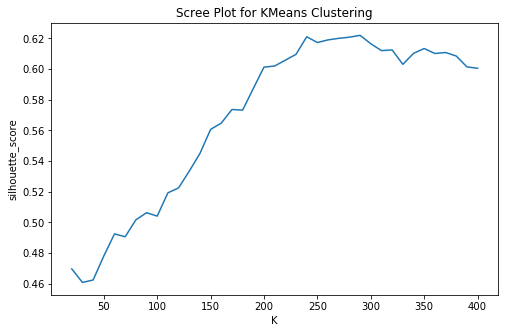

In [12]:
# Plot the silhouette for different K's
plt.figure(figsize=(8,5))
plt.plot(silhouette_result['k'], silhouette_result['silhouette_score'])
plt.xlabel('K')
plt.ylabel('silhouette_score')
plt.title('Scree Plot for KMeans Clustering');

In [13]:
# Get the best number of cluseter K
best_k = silhouette_result['k'][silhouette_result['silhouette_score'].idxmax()]
best_k

290

In [14]:
# Fit Kmeans Model to the coordinates
kmeans = KMeans(n_clusters=best_k, random_state=314).fit(business_df[['latitude', 'longitude']].copy())

# Add the cluster labels to data
business_df['cluster'] = kmeans.labels_

In [15]:
# Calculate number of restaurants in each centroid
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['latitude', 'longitude']) \
                .reset_index() \
                .rename(columns={'index':'k'})
centroids['size'] = business_df.groupby('cluster').size()
centroids.head()

k   latitude   longitude  size
0  0  33.655133 -112.133148     4
1  1  33.435889 -111.997687    46
2  2  33.509863 -112.117417     6
3  3  33.676321 -111.975210    36
4  4  33.465866 -112.073997    12

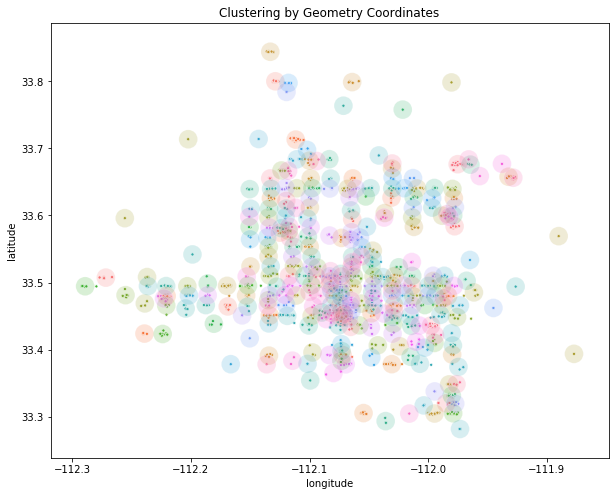

In [16]:
# Visualize the geometry clustering
plt.figure(figsize=(10,8))
cmap=sns.husl_palette(n_colors=best_k)
sns.scatterplot('longitude', 'latitude', hue='cluster', data=business_df, legend=False, s=10, palette=cmap)
sns.scatterplot('longitude', 'latitude', hue='k', data=centroids, legend=False, s=350, alpha=0.2, palette=cmap)
plt.title('Clustering by Geometry Coordinates');

In [17]:
# Compute neighborhood density for each cluster
neighborhood = centroids.set_index('k')['size'].to_dict()
business_df['neighborhood'] = business_df['cluster'].apply(lambda row: neighborhood[row])

## 3.1.3 Finalize Business Feature

In [19]:
# Drop orginal arrtributes in business
var_to_drop = ['attributes', 'categories', 'cluster']
business_df = business_df.drop(var_to_drop, axis=1)

In [20]:
# Change variable name
business_df = business_df.rename(columns={'stars':'star_rating'})

In [21]:
# Check dimensions
business_df.shape

(2493, 13)

In [22]:
# Check first few rows of finalized business data
business_df.head()

business_id     city   latitude   longitude  \
0  rDMptJYWtnMhpQu_rRXHng  Phoenix  33.607070 -112.064382   
1  1WBkAuQg81kokZIPMpn9Zg  Phoenix  33.607310 -112.063404   
2  iPa__LOhse-hobC2Xmp-Kw  Phoenix  33.508765 -112.046240   
3  YhV93k9uiMdr3FlV4FHjwA  Phoenix  33.449967 -112.070222   
4  QkG3KUXwqZBW18A9k1xqCA  Phoenix  33.478735 -112.221379   

                           name  postal_code  review_count  star_rating state  \
0                    McDonald's        85022            10          1.0    AZ   
1  Charr An American Burger Bar        85022           232          3.0    AZ   
2                    McDonald's        85016            34          3.0    AZ   
3               Caviness Studio        85001             4          5.0    AZ   
4                   Red Lobster        85035            37          2.5    AZ   

   isBankrupt           county  isChain  neighborhood  
0           0  Maricopa County        1            13  
1           0  Maricopa County        0            13  
2           0  Maricopa County        1            22  
3           0  Maricopa County        0            38  
4           0  Maricopa County        1            15

In [23]:
# Check for missing values
business_df.isna().sum()

business_id     0
city            0
latitude        0
longitude       0
name            0
postal_code     0
review_count    0
star_rating     0
state           0
isBankrupt      0
county          0
isChain         0
neighborhood    0
dtype: int64

## 3.2 Extract Review Features

In [24]:
# Load review data
review = pd.read_csv('clean_review.csv')
review.shape

(282385, 8)

In [25]:
# Look at the first few rows of data
review.head()

business_id  cool        date  funny  stars  useful  \
0  JlNeaOymdVbE6_bubqjohg     0  2014-08-09      0      1       3   
1  0Rni7ocMC_Lg2UH0lDeKMQ     0  2014-08-09      0      1       6   
2  S-oLPRdhlyL5HAknBKTUcQ     0  2017-11-30      0      4       0   
3  iIjVO7cLD1UEmIO7G05Ujw     0  2016-06-11      0      4       0   
4  1JF9TbJ2d5hH8xsQvvklHg     0  2016-06-18      0      5       1   

   review_length                                         clean_text  
0             81  chevo chandler delicious ahwatukee different r...  
1             21           place dirty grimy twice service horrible  
2             25  holy portion size lot bang buck service super ...  
3             60  flavor actually pretty good eat menudo tortill...  
4             94  place great flavor thing ask bring chip salsa ...

In [26]:
# Make a copy of the original data
review_df = review.copy()

## 3.2.1 Create Bag-of-Words Model

We utilize `gensim` library to create bag-of-word models.

The processing steps are shown below:

1. Create corpus from review data.

2. Generate bigrams

3. Create corpus dictionary 

4. Create term-document matrix

5. Compute TF-IDF scores

In [27]:
# Convert string to list
corpus = review_df['clean_text'].apply(lambda x: simple_preprocess(str(x)))

In [28]:
# Creates bigrams
phrases = Phrases(corpus, min_count=1, threshold=1)
corpus = [doc + [bigram for bigram in phrases[doc] if '_' in bigram] for doc in corpus]

In [29]:
# Create a word dictionary
dictionary = Dictionary(corpus)
dictionary.filter_extremes()
dictionary.compactify()

In [30]:
# Create bad-of-word corpus
bow_corpus = [dictionary.doc2bow(doc) for doc in corpus]

In [31]:
# Compute tf-idf
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

## 3.2.2 Topic Modeling

In [32]:
# Run lda model with 10 topics
lda = LdaModel(corpus=tfidf_corpus, num_topics=10, id2word=dictionary, random_state=314)

In [33]:
# Show the components of each topic
lda.show_topics()

[(0,
  '0.017*"great" + 0.011*"love" + 0.011*"service" + 0.011*"friendly" + 0.010*"amazing" + 0.010*"food" + 0.010*"recommend" + 0.010*"staff" + 0.009*"atmosphere" + 0.009*"awesome"'),
 (1,
  '0.009*"donut" + 0.007*"breakfast" + 0.006*"toast" + 0.005*"egg" + 0.005*"hash" + 0.004*"french_toast" + 0.004*"pancake" + 0.004*"hash_brown" + 0.004*"bacon" + 0.004*"brown"'),
 (2,
  '0.008*"order" + 0.007*"minute" + 0.007*"wait" + 0.006*"ask" + 0.006*"time" + 0.005*"service" + 0.005*"take" + 0.005*"customer" + 0.005*"food" + 0.005*"say"'),
 (3,
  '0.005*"pizza" + 0.005*"place" + 0.005*"great" + 0.005*"good" + 0.004*"food" + 0.004*"time" + 0.004*"try" + 0.004*"love" + 0.003*"come" + 0.003*"order"'),
 (4,
  '0.010*"bagel" + 0.007*"coffee" + 0.006*"crepe" + 0.006*"latte" + 0.005*"dog" + 0.004*"breakfast" + 0.003*"portion_large" + 0.003*"muffin" + 0.003*"english" + 0.003*"order_online"'),
 (5,
  '0.007*"pricy" + 0.006*"orange_chicken" + 0.005*"pastor" + 0.004*"terrible_service" + 0.004*"chimichanga"

In [34]:
# Add topic label manually
topic_label = ['Service_Quality',
               'Breakfast_Description',
               'Order_Wait_Time',
               'Dining_Experience',
               'Coffee_Pastry_PortionSize',
               'Price_Service',
               'Asian_Food_Description',
               'Gluten_Free_Food',
               'Mexican_Food_Description',
               'Fast_Food_Description']
topic_dict = {i:topic_label[i] for i in range(lda.num_topics)}

In [35]:
def find_dominant_topic(x):
    topic_percent = [j for i, j in x]
    return topic_percent.index(max(topic_percent))

In [36]:
# Compute the dominant topic for each review
dominant_topic = pd.get_dummies([find_dominant_topic(x) for x in lda[tfidf_corpus]]).rename(columns=topic_dict)
dominant_topic.head()

Service_Quality  Breakfast_Description  Order_Wait_Time  Dining_Experience  \
0                0                      0                0                  1   
1                0                      0                1                  0   
2                0                      0                0                  0   
3                0                      0                0                  0   
4                0                      0                0                  0   

   Coffee_Pastry_PortionSize  Price_Service  Asian_Food_Description  \
0                          0              0                       0   
1                          0              0                       0   
2                          0              0                       0   
3                          0              0                       0   
4                          0              0                       0   

   Gluten_Free_Food  Mexican_Food_Description  Fast_Food_Description  
0                 0                         0                      0  
1                 0                         0                      0  
2                 0                         0                      1  
3                 0                         1                      0  
4                 0                         1                      0

In [37]:
# Merge topic into review data
review_df = review_df.merge(dominant_topic, left_index=True, right_index=True)
review_df.shape

(282385, 18)

In [38]:
# Look at first few rows of data
review_df.head()

business_id  cool        date  funny  stars  useful  \
0  JlNeaOymdVbE6_bubqjohg     0  2014-08-09      0      1       3   
1  0Rni7ocMC_Lg2UH0lDeKMQ     0  2014-08-09      0      1       6   
2  S-oLPRdhlyL5HAknBKTUcQ     0  2017-11-30      0      4       0   
3  iIjVO7cLD1UEmIO7G05Ujw     0  2016-06-11      0      4       0   
4  1JF9TbJ2d5hH8xsQvvklHg     0  2016-06-18      0      5       1   

   review_length                                         clean_text  \
0             81  chevo chandler delicious ahwatukee different r...   
1             21           place dirty grimy twice service horrible   
2             25  holy portion size lot bang buck service super ...   
3             60  flavor actually pretty good eat menudo tortill...   
4             94  place great flavor thing ask bring chip salsa ...   

   Service_Quality  Breakfast_Description  Order_Wait_Time  Dining_Experience  \
0                0                      0                0                  1   
1                0                      0                1                  0   
2                0                      0                0                  0   
3                0                      0                0                  0   
4                0                      0                0                  0   

   Coffee_Pastry_PortionSize  Price_Service  Asian_Food_Description  \
0                          0              0                       0   
1                          0              0                       0   
2                          0              0                       0   
3                          0              0                       0   
4                          0              0                       0   

   Gluten_Free_Food  Mexican_Food_Description  Fast_Food_Description  
0                 0                         0                      0  
1                 0                         0                      0  
2                 0                         0                      1  
3                 0                         1                      0  
4                 0                         1                      0

## 3.2.3 Sentiment Score

In [39]:
# Compute sentiment score
review_df['polarity'] = review_df['clean_text'].apply(lambda sent: TextBlob(str(sent)).sentiment.polarity)
review_df['subjectivity'] = review_df['clean_text'].apply(lambda sent: TextBlob(str(sent)).sentiment.subjectivity)

## 3.2.4 Restaurant Age

In [40]:
# Convert string date to datetime format
review_df['date'] = review_df['date'].apply(lambda x: pd.to_datetime(x))

In [41]:
# Create dictionary of estimated restaurant age
restaurant_age = review_df[['business_id', 'date']].groupby('business_id') \
                                                    .agg(lambda x: pd.datetime(2017, 12, 31) - min(x))['date'] \
                                                    .apply(lambda x: x.days / 365) \
                                                    .to_dict()

## 3.2.5 Combine Clean Text

In [42]:
# Join clean text data by business id
text_df = review.groupby('business_id')['clean_text'].agg(lambda x: ' '.join(x.astype(str))).reset_index()

## 3.2.6 Finalize Review Features

In [43]:
# Take the mean of numeric features group by business id
review_df = review_df.groupby('business_id').mean().reset_index()

In [44]:
# Add restaurant age to the grouped dataset
review_df['restaurant_age'] = review_df['business_id'].apply(lambda row: restaurant_age[row])
review_df.shape

(2493, 19)

In [45]:
# Merge clean text to grouped review data
review_df = review_df.merge(text_df, on='business_id')

In [46]:
# View the first few lines of data 
review_df.head()

business_id      cool     funny     stars    useful  \
0  -0WegMt6Cy966qlDKhu6jA  0.376623  0.246753  2.142857  0.662338   
1  -0aIra_B6iALlfqAriBSYA  0.562500  0.375000  4.625000  0.937500   
2  -0tgMGl7D9B10YjSN2ujLA  0.533333  0.516667  3.316667  1.266667   
3  -1UMR00eXtwaeh59pEiDjA  0.541538  0.424615  3.440000  0.738462   
4  -2isRNVb6PDuBagELL5EBw  0.400000  0.500000  3.100000  0.350000   

   review_length  Service_Quality  Breakfast_Description  Order_Wait_Time  \
0     124.688312         0.025974               0.012987         0.285714   
1      75.406250         0.000000               0.000000         0.093750   
2      86.233333         0.041667               0.000000         0.183333   
3      87.572308         0.036923               0.012308         0.196923   
4      94.900000         0.000000               0.000000         0.450000   

   Dining_Experience  Coffee_Pastry_PortionSize  Price_Service  \
0           0.662338                    0.00000            0.0   
1           0.812500                    0.03125            0.0   
2           0.741667                    0.00000            0.0   
3           0.581538                    0.00000            0.0   
4           0.550000                    0.00000            0.0   

   Asian_Food_Description  Gluten_Free_Food  Mexican_Food_Description  \
0                0.000000               0.0                  0.000000   
1                0.031250               0.0                  0.000000   
2                0.000000               0.0                  0.000000   
3                0.003077               0.0                  0.073846   
4                0.000000               0.0                  0.000000   

   Fast_Food_Description  polarity  subjectivity  restaurant_age  \
0               0.012987 -0.022920      0.545097        4.712329   
1               0.031250  0.324154      0.589466        2.531507   
2               0.033333  0.206119      0.565569       11.849315   
3               0.095385  0.242347      0.607857        3.778082   
4               0.000000  0.139920      0.622042        9.410959   

                                          clean_text  
0  notice positive review end pay shill place dif...  
1  like iced tea place big selection freshly brew...  
2  wife chicken boxty pie wonderful come sure goo...  
3  time airport pleasant surprise great breakfast...  
4  expect detailed review menu look shit serve lo...

## 3.3 Export Finalized Dataset

In [47]:
# Combined both dataset and combine the next cell into one dataset
final_df = business_df.merge(review_df, on='business_id')
final_df.shape

(2493, 32)

In [48]:
# View the first few rows of data 
final_df.head()

business_id     city   latitude   longitude  \
0  rDMptJYWtnMhpQu_rRXHng  Phoenix  33.607070 -112.064382   
1  1WBkAuQg81kokZIPMpn9Zg  Phoenix  33.607310 -112.063404   
2  iPa__LOhse-hobC2Xmp-Kw  Phoenix  33.508765 -112.046240   
3  YhV93k9uiMdr3FlV4FHjwA  Phoenix  33.449967 -112.070222   
4  QkG3KUXwqZBW18A9k1xqCA  Phoenix  33.478735 -112.221379   

                           name  postal_code  review_count  star_rating state  \
0                    McDonald's        85022            10          1.0    AZ   
1  Charr An American Burger Bar        85022           232          3.0    AZ   
2                    McDonald's        85016            34          3.0    AZ   
3               Caviness Studio        85001             4          5.0    AZ   
4                   Red Lobster        85035            37          2.5    AZ   

   isBankrupt           county  isChain  neighborhood      cool     funny  \
0           0  Maricopa County        1            13  0.363636  0.909091   
1           0  Maricopa County        0            13  0.370690  0.422414   
2           0  Maricopa County        1            22  0.264706  0.529412   
3           0  Maricopa County        0            38  0.000000  0.000000   
4           0  Maricopa County        1            15  0.162162  0.324324   

      stars    useful  review_length  Service_Quality  Breakfast_Description  \
0  1.090909  1.454545      43.363636         0.000000               0.000000   
1  3.155172  1.625000     112.676724         0.047414               0.004310   
2  2.764706  0.705882     103.411765         0.029412               0.000000   
3  5.000000  0.250000      92.500000         0.000000               0.000000   
4  2.648649  0.756757     111.918919         0.081081               0.027027   

   Order_Wait_Time  Dining_Experience  Coffee_Pastry_PortionSize  \
0         0.545455           0.272727                   0.090909   
1         0.185345           0.612069                   0.000000   
2         0.558824           0.323529                   0.000000   
3         0.000000           1.000000                   0.000000   
4         0.459459           0.432432                   0.000000   

   Price_Service  Asian_Food_Description  Gluten_Free_Food  \
0            0.0                     0.0               0.0   
1            0.0                     0.0               0.0   
2            0.0                     0.0               0.0   
3            0.0                     0.0               0.0   
4            0.0                     0.0               0.0   

   Mexican_Food_Description  Fast_Food_Description  polarity  subjectivity  \
0                  0.000000               0.090909 -0.161032      0.494729   
1                  0.012931               0.137931  0.243730      0.626364   
2                  0.058824               0.029412  0.037716      0.568482   
3                  0.000000               0.000000  0.391310      0.685331   
4                  0.000000               0.000000  0.099518      0.652154   

   restaurant_age                                         clean_text  
0        6.575342  speed delivery food order terrible take minute...  
1        5.526027  place way successful run good customer service...  
2        9.641096  awesome breakfast good store clean clean porti...  
3        1.501370  custom shirt order design silk screen print te...  
4        5.715068  food good service great waiter think attentive...

In [49]:
# Export datasets
final_df.to_csv('final_dataset.csv', index=False)

# 4. Exploratory Data Analysis

In [70]:
# Install important python package
if True: 
    ! pip install -q wordcloud
    ! pip install -q imblearn

In [2]:
# Basic python package
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Import package for EDA
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.decomposition import PCA

In [4]:
# Import packages for classification
from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [5]:
# Disable row and column truncation
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
# Read final dataset
data = pd.read_csv('final_dataset.csv')
data.shape

(2493, 32)

In [7]:
# Reveal first few rows 
data.head()

business_id     city   latitude   longitude  \
0  rDMptJYWtnMhpQu_rRXHng  Phoenix  33.607070 -112.064382   
1  1WBkAuQg81kokZIPMpn9Zg  Phoenix  33.607310 -112.063404   
2  iPa__LOhse-hobC2Xmp-Kw  Phoenix  33.508765 -112.046240   
3  YhV93k9uiMdr3FlV4FHjwA  Phoenix  33.449967 -112.070223   
4  QkG3KUXwqZBW18A9k1xqCA  Phoenix  33.478735 -112.221379   

                           name  postal_code  review_count  star_rating state  \
0                    McDonald's        85022            10          1.0    AZ   
1  Charr An American Burger Bar        85022           232          3.0    AZ   
2                    McDonald's        85016            34          3.0    AZ   
3               Caviness Studio        85001             4          5.0    AZ   
4                   Red Lobster        85035            37          2.5    AZ   

   isBankrupt           county  isChain  neighborhood      cool     funny  \
0           0  Maricopa County        1            13  0.363636  0.909091   
1           0  Maricopa County        0            13  0.370690  0.422414   
2           0  Maricopa County        1            22  0.264706  0.529412   
3           0  Maricopa County        0            38  0.000000  0.000000   
4           0  Maricopa County        1            15  0.162162  0.324324   

      stars    useful  review_length  Service_Quality  Breakfast_Description  \
0  1.090909  1.454545      43.363636         0.000000               0.000000   
1  3.155172  1.625000     112.676724         0.047414               0.004310   
2  2.764706  0.705882     103.411765         0.029412               0.000000   
3  5.000000  0.250000      92.500000         0.000000               0.000000   
4  2.648649  0.756757     111.918919         0.081081               0.027027   

   Order_Wait_Time  Dining_Experience  Coffee_Pastry_PortionSize  \
0         0.545455           0.272727                   0.090909   
1         0.185345           0.612069                   0.000000   
2         0.558824           0.323529                   0.000000   
3         0.000000           1.000000                   0.000000   
4         0.459459           0.432432                   0.000000   

   Price_Service  Asian_Food_Description  Gluten_Free_Food  \
0            0.0                     0.0               0.0   
1            0.0                     0.0               0.0   
2            0.0                     0.0               0.0   
3            0.0                     0.0               0.0   
4            0.0                     0.0               0.0   

   Mexican_Food_Description  Fast_Food_Description  polarity  subjectivity  \
0                  0.000000               0.090909 -0.161032      0.494729   
1                  0.012931               0.137931  0.243730      0.626364   
2                  0.058824               0.029412  0.037716      0.568482   
3                  0.000000               0.000000  0.391310      0.685331   
4                  0.000000               0.000000  0.099518      0.652154   

   restaurant_age                                         clean_text  
0        6.575342  speed delivery food order terrible take minute...  
1        5.526027  place way successful run good customer service...  
2        9.641096  awesome breakfast good store clean clean porti...  
3        1.501370  custom shirt order design silk screen print te...  
4        5.715068  food good service great waiter think attentive...

In [8]:
# Make a copy of raw dataset
df = data.copy()

In [9]:
# Drop unnecessary variables
var_to_drop = ['business_id', 'city', 'latitude', 'longitude', 'name', 'postal_code', 'state', 'county', 'clean_text']
df = df.drop(var_to_drop, axis=1)
df.shape

(2493, 23)

In [10]:
# Check first few rows of data
df.head()

review_count  star_rating  isBankrupt  isChain  neighborhood      cool  \
0            10          1.0           0        1            13  0.363636   
1           232          3.0           0        0            13  0.370690   
2            34          3.0           0        1            22  0.264706   
3             4          5.0           0        0            38  0.000000   
4            37          2.5           0        1            15  0.162162   

      funny     stars    useful  review_length  Service_Quality  \
0  0.909091  1.090909  1.454545      43.363636         0.000000   
1  0.422414  3.155172  1.625000     112.676724         0.047414   
2  0.529412  2.764706  0.705882     103.411765         0.029412   
3  0.000000  5.000000  0.250000      92.500000         0.000000   
4  0.324324  2.648649  0.756757     111.918919         0.081081   

   Breakfast_Description  Order_Wait_Time  Dining_Experience  \
0               0.000000         0.545455           0.272727   
1               0.004310         0.185345           0.612069   
2               0.000000         0.558824           0.323529   
3               0.000000         0.000000           1.000000   
4               0.027027         0.459459           0.432432   

   Coffee_Pastry_PortionSize  Price_Service  Asian_Food_Description  \
0                   0.090909            0.0                     0.0   
1                   0.000000            0.0                     0.0   
2                   0.000000            0.0                     0.0   
3                   0.000000            0.0                     0.0   
4                   0.000000            0.0                     0.0   

   Gluten_Free_Food  Mexican_Food_Description  Fast_Food_Description  \
0               0.0                  0.000000               0.090909   
1               0.0                  0.012931               0.137931   
2               0.0                  0.058824               0.029412   
3               0.0                  0.000000               0.000000   
4               0.0                  0.000000               0.000000   

   polarity  subjectivity  restaurant_age  
0 -0.161032      0.494729        6.575342  
1  0.243730      0.626364        5.526027  
2  0.037716      0.568482        9.641096  
3  0.391310      0.685331        1.501370  
4  0.099518      0.652154        5.715068

## 4.1 Summary Statistics

In [11]:
# Generate basic variable summary
df.describe().T

count        mean         std        min  \
review_count               2493.0  113.270758  188.476268   3.000000   
star_rating                2493.0    3.424789    0.867333   1.000000   
isBankrupt                 2493.0    0.061372    0.240059   0.000000   
isChain                    2493.0    0.410349    0.491996   0.000000   
neighborhood               2493.0   14.208985   10.263388   1.000000   
cool                       2493.0    0.533981    0.586501   0.000000   
funny                      2493.0    0.483094    0.544059   0.000000   
stars                      2493.0    3.422489    0.853534   1.000000   
useful                     2493.0    1.047033    0.784494   0.000000   
review_length              2493.0   94.495912   28.130013  28.000000   
Service_Quality            2493.0    0.055934    0.061295   0.000000   
Breakfast_Description      2493.0    0.003288    0.012828   0.000000   
Order_Wait_Time            2493.0    0.232456    0.192690   0.000000   
Dining_Experience          2493.0    0.535288    0.186753   0.000000   
Coffee_Pastry_PortionSize  2493.0    0.004469    0.025876   0.000000   
Price_Service              2493.0    0.000510    0.004370   0.000000   
Asian_Food_Description     2493.0    0.016482    0.046103   0.000000   
Gluten_Free_Food           2493.0    0.001231    0.009464   0.000000   
Mexican_Food_Description   2493.0    0.076283    0.137768   0.000000   
Fast_Food_Description      2493.0    0.074058    0.093648   0.000000   
polarity                   2493.0    0.213020    0.132149  -0.303299   
subjectivity               2493.0    0.606941    0.046427   0.223750   
restaurant_age             2493.0    6.052926    3.343613   0.076712   

                                 25%        50%         75%          max  
review_count               13.000000  43.000000  134.000000  2035.000000  
star_rating                 3.000000   3.500000    4.000000     5.000000  
isBankrupt                  0.000000   0.000000    0.000000     1.000000  
isChain                     0.000000   0.000000    1.000000     1.000000  
neighborhood                7.000000  11.000000   18.000000    48.000000  
cool                        0.250000   0.431741    0.666667    13.500000  
funny                       0.214286   0.379310    0.597222     9.333333  
stars                       2.857143   3.562500    4.061947     5.000000  
useful                      0.593750   0.916667    1.322785    13.500000  
review_length              77.520000  92.007812  107.821429   430.833333  
Service_Quality             0.000000   0.043956    0.086022     0.666667  
Breakfast_Description       0.000000   0.000000    0.000000     0.333333  
Order_Wait_Time             0.090909   0.174603    0.333333     1.000000  
Dining_Experience           0.408602   0.535484    0.666667     1.000000  
Coffee_Pastry_PortionSize   0.000000   0.000000    0.000000     0.800000  
Price_Service               0.000000   0.000000    0.000000     0.083333  
Asian_Food_Description      0.000000   0.000000    0.004902     0.500000  
Gluten_Free_Food            0.000000   0.000000    0.000000     0.333333  
Mexican_Food_Description    0.000000   0.012945    0.066667     0.888889  
Fast_Food_Description       0.000000   0.046512    0.104167     0.750000  
polarity                    0.136961   0.237061    0.307731     0.643750  
subjectivity                0.582815   0.610868    0.635784     0.820333  
restaurant_age              3.254795   6.076712    8.991781    12.824658

## 4.2 Pairplot

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


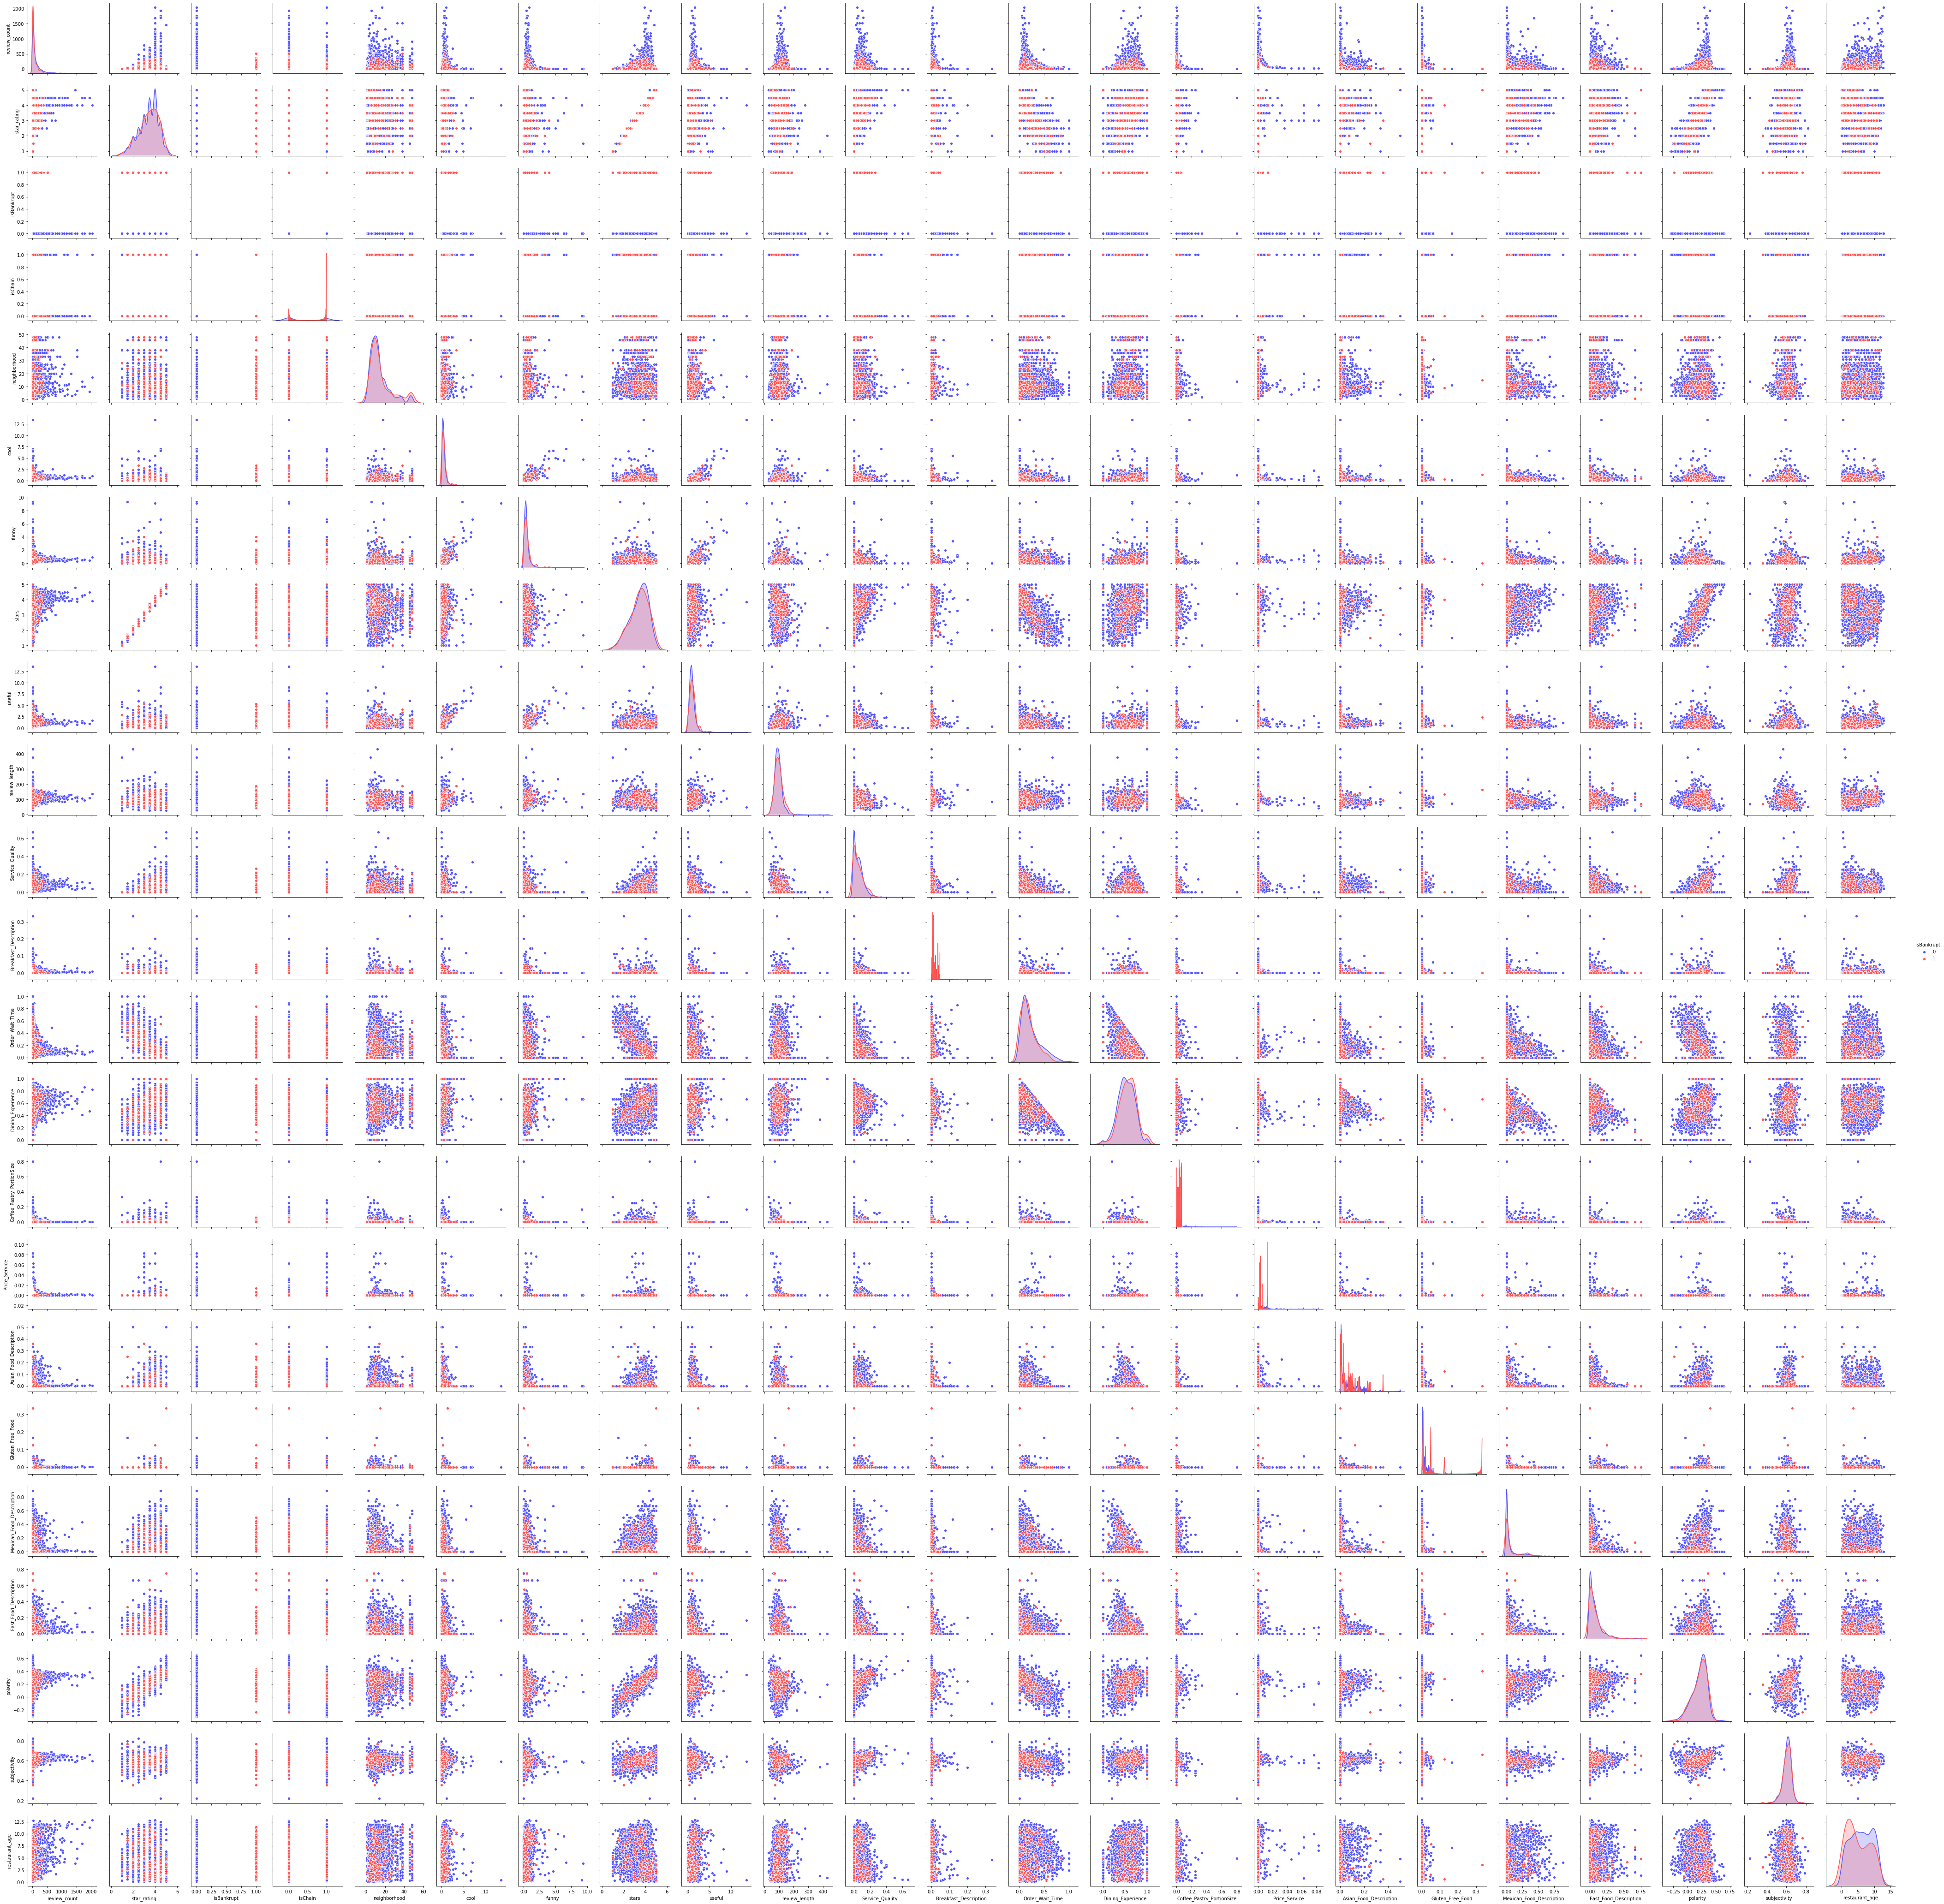

In [12]:
# Make pairplot across all variables
sns.pairplot(df, hue='isBankrupt', palette='seismic');

Some observations: <br>
- Many open restaurants have high values in `review_count`. <br>
- `star_rating` has postive relationships with `Service_Quality` and `polarity` and negative relationship with `Order_Wait_Time`. <br>
- There are special shapes in `neighborhood`.
- `cool` has positive relationships with `funny` and `useful`.<br>
- `stars` has positive relationship with `polaity` and negative relationship with `Order_Wait_Time`.<br>
- `Order_Wait_Time` has negative relationship with `polaity`.
- `Dining_Experience` has negative relationship with `polarity`.

## 4.3 Heatmap

## 4.3.1 Correlation Matrix

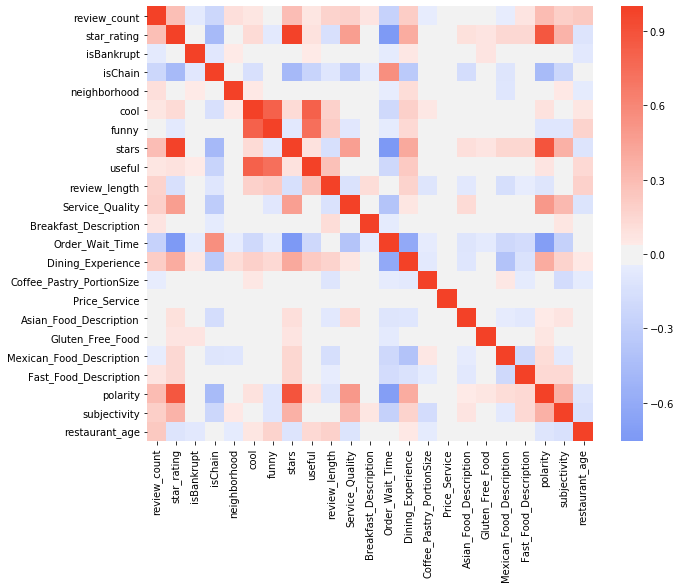

In [13]:
# Plot Heatmap of correlation matrix
plt.figure(figsize=(10,8))
color_palette = sns.diverging_palette(260, 15, s=90, l=55, as_cmap = True)
sns.heatmap(df.corr(), cmap=color_palette,center=0);

Some observations: <br>
- `isBankrupt` has positive relationships with `neighborhood`, `useful`, `Dining_Experience` and `Gluten_Free_Food` and negative relationships with `review_count`, `isChain`, `Order_Wait_Time` and `restaurant_age`.<br>
- Other useful strong positive relationship: `star_rating` and `polarity`; `cool` and `funny`; `cool` and `useful`; `funny` and `useful`. <br>
- Other useful strong negative relationship: `star_rating` and `Order_Wait_Time`.

## 4.3.2 Hierarchical Clustering

<Figure size 720x576 with 0 Axes>

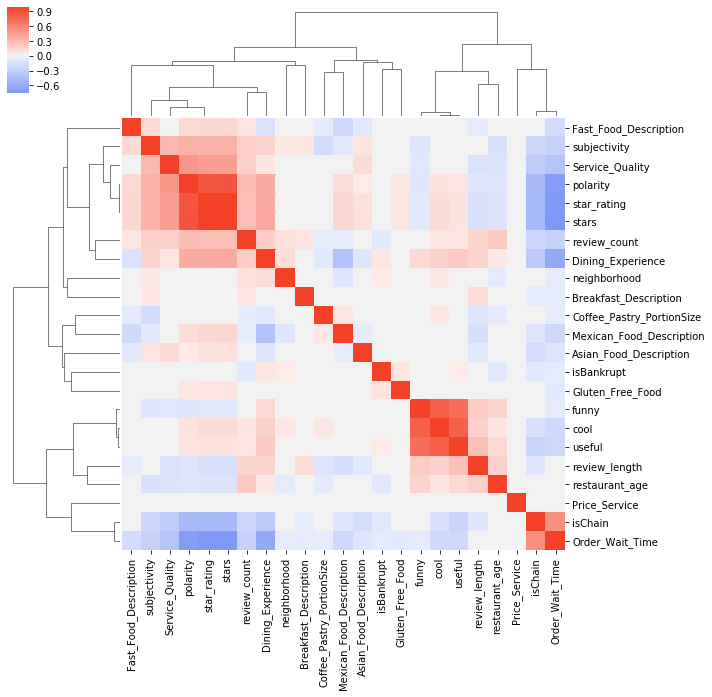

In [14]:
# Perform hierarchical clustering using complete linkage by correlation
plt.figure(figsize=(10,8))
color_palette = sns.diverging_palette(260, 15, s=90, l=55, as_cmap = True)
sns.clustermap(df.corr(), method='complete', metric='correlation',cmap=color_palette, center=0);

## 4.4 Histogram

## 4.4.1 Neighborhood Size

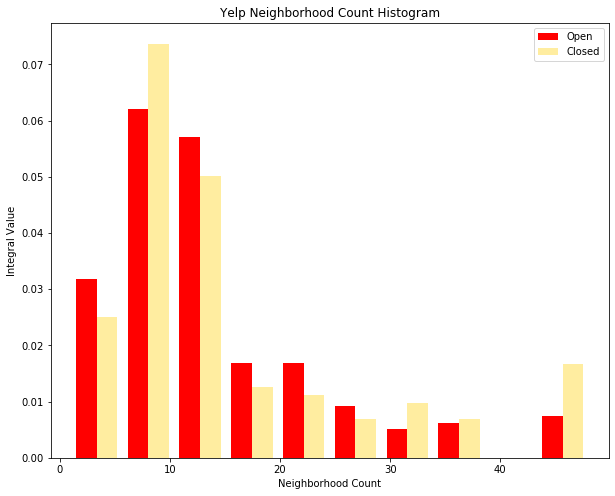

In [15]:
# Histogram of normalized neighborhood size
plt.figure(figsize=(10,8))
plt.hist([df['neighborhood'][df['isBankrupt']==0],\
          df['neighborhood'][df['isBankrupt']==1]],\
         label=['Open','Closed'], color=['red','#ffeda0'], density=True)
plt.legend()
plt.title('Yelp Neighborhood Count Histogram')
plt.xlabel('Neighborhood Count')
plt.ylabel('Integral Value');

Bankrupt Restaurants have high concentration in having 5 to 10 neighborhoods and above 40 neighborhoods.

## 4.4.2 Averege Review Usefulness

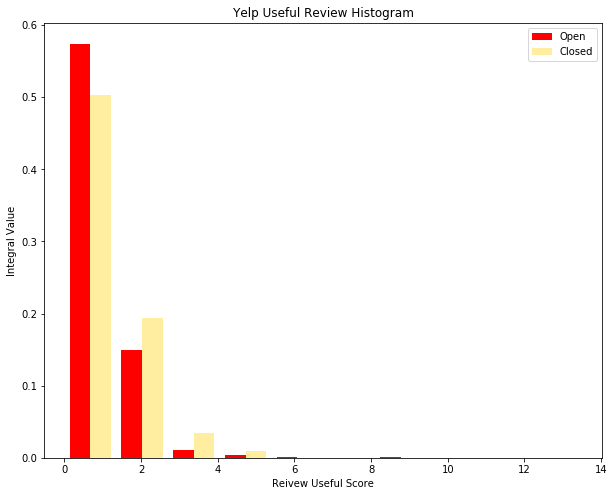

In [16]:
# Histogram of normalized review_count
plt.figure(figsize=(10,8))
plt.hist([df['useful'][df['isBankrupt']==0],\
          df['useful'][df['isBankrupt']==1]],\
         label=['Open','Closed'], color=['red','#ffeda0'],density=True)
plt.legend()
plt.title('Yelp Useful Review Histogram')
plt.xlabel('Reivew Useful Score')
plt.ylabel('Integral Value');

The review for bankrupt restaurants are relatively more useful.

## 4.4.3 Dining Experience

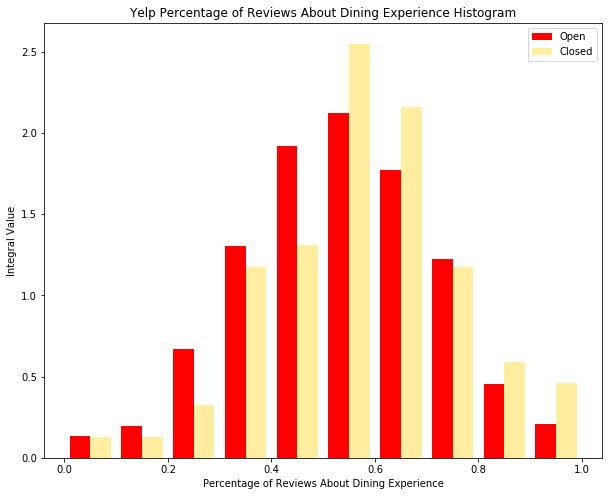

In [17]:
# Histogram of normalized dining experience
plt.figure(figsize=(10,8))
plt.hist([df['Dining_Experience'][df['isBankrupt']==0].dropna(),\
          df['Dining_Experience'][df['isBankrupt']==1].dropna()],\
         label=['Open','Closed'], color=['red','#ffeda0'], density=True)
plt.legend()
plt.title('Yelp Percentage of Reviews About Dining Experience Histogram')
plt.xlabel('Percentage of Reviews About Dining Experience')
plt.ylabel('Integral Value');

Bankrupt restaurants are more likely to contain reviews about dining experience.

## 4.4.4 Review Count

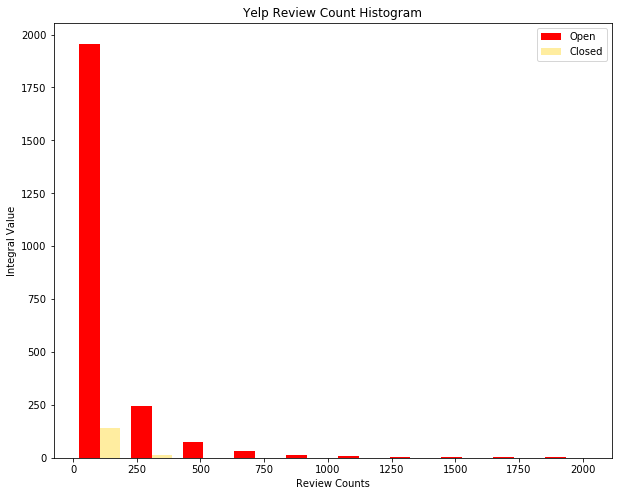

In [18]:
# Histogram of unnormalized review_count
plt.figure(figsize=(10,8))
plt.hist([df['review_count'][df['isBankrupt']==0].dropna(),\
          df['review_count'][df['isBankrupt']==1].dropna()],\
         label=['Open','Closed'], color=['red','#ffeda0'])
plt.legend()
plt.title('Yelp Review Count Histogram')
plt.xlabel('Review Counts')
plt.ylabel('Integral Value');

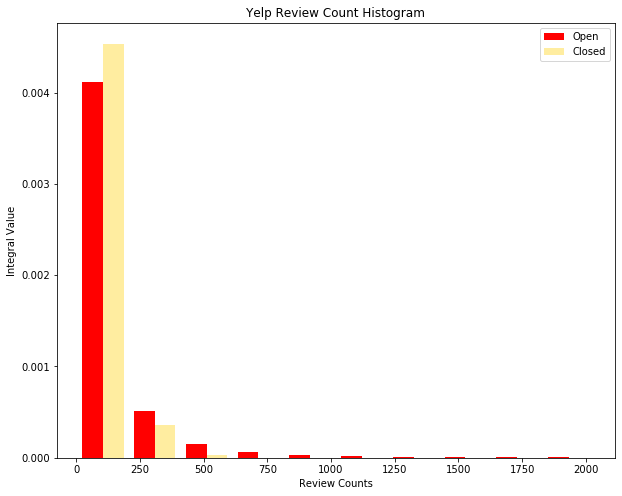

In [19]:
# Histogram of normalized review_count
plt.figure(figsize=(10,8))
plt.hist([df['review_count'][df['isBankrupt']==0].dropna(),\
          df['review_count'][df['isBankrupt']==1].dropna()],\
         label=['Open','Closed'], color=['red','#ffeda0'], density=True)
plt.legend()
plt.title('Yelp Review Count Histogram')
plt.xlabel('Review Counts')
plt.ylabel('Integral Value');

Compared to non-bankrupt restaurants, more percentage of bankrupt restaurants have 0 to 250 reviews.

## 4.4.5 isChain

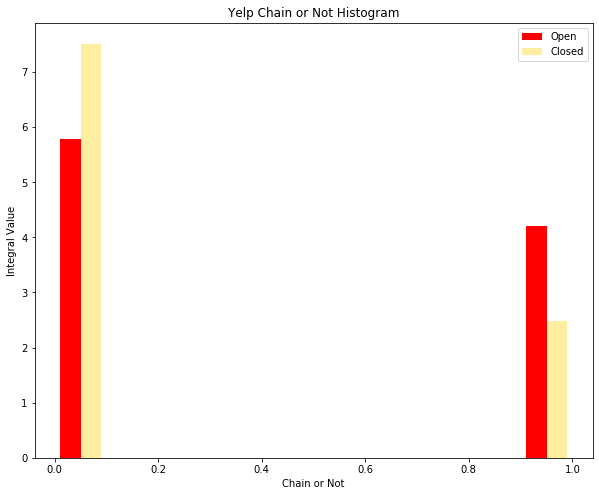

In [20]:
# Histogram of normalized isChain
plt.figure(figsize=(10,8))
plt.hist([df['isChain'][df['isBankrupt']==0],\
          df['isChain'][df['isBankrupt']==1]],\
         label=['Open','Closed'], color=['red','#ffeda0'],density=True)
plt.legend()
plt.title('Yelp Chain or Not Histogram')
plt.xlabel('Chain or Not')
plt.ylabel('Integral Value');

Chain restaurants are less likely to be bankrupt.

## 4.4.6 Order Wait Time

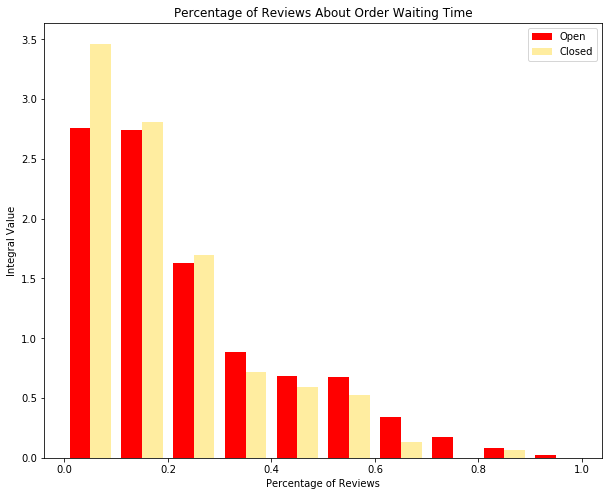

In [21]:
# Histogram of normalized order wait time
plt.figure(figsize=(10,8))
plt.hist([df['Order_Wait_Time'][df['isBankrupt']==0],\
          df['Order_Wait_Time'][df['isBankrupt']==1]],\
         label=['Open','Closed'], color=['red','#ffeda0'],density=True)
plt.legend()
plt.title('Percentage of Reviews About Order Waiting Time')
plt.xlabel('Percentage of Reviews')
plt.ylabel('Integral Value');

Restaurants with low percentage of reviews about order waiting time are more likely to be bankrupt.

## 4.4.7 Restaurant Age

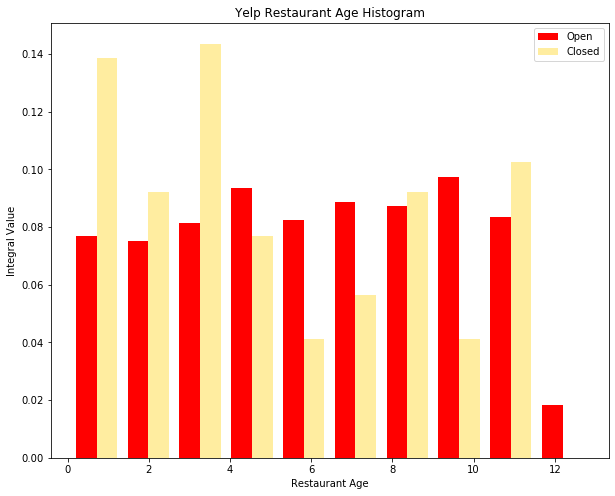

In [22]:
# Histogram of normalized restaurant age
plt.figure(figsize=(10,8))
plt.hist([df['restaurant_age'][df['isBankrupt']==0],\
          df['restaurant_age'][df['isBankrupt']==1]],\
         label=['Open','Closed'], color=['red','#ffeda0'],density=True)
plt.legend()
plt.title('Yelp Restaurant Age Histogram')
plt.xlabel('Restaurant Age')
plt.ylabel('Integral Value');

Restaurants are more likely to be bankrupt in the first few years after opening; Besides, it would also be hard for restaurants to be open over 10 years.

## 4.5 Word Cloud

It may be a good idea to plot a word cloud of all text in the review data. However, since the dataset is too large to create a word cloud using all restaurant review data. Therefore, to get a feel of the review text data, we will only plot the word cloud for the first 1000 restaurant reviews.

In [23]:
# Extract all words it the dataset
text = ' '.join(str(review) for review in data['clean_text'].head(1000))

In [24]:
# Read in the image as the mask fo rhte word cloud
mask = np.array(Image.open('yelp-icon.png'))

In [25]:
# Generate wordcloud object
wc = WordCloud(font_path='Roboto-Regular.ttf',
               max_font_size=100, 
               background_color='white', 
               mask=mask, 
               max_words=2000, 
               colormap='Dark2', 
               random_state=314)

In [26]:
# Generate word cloud using text
wc.generate(text)

In [27]:
# Extract the color of the original data
image_colors = ImageColorGenerator(mask)

(-0.5, 636.5, 636.5, -0.5)

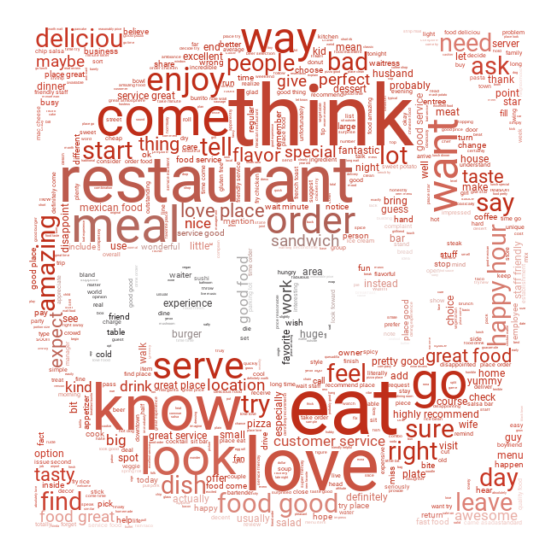

In [28]:
# Plot the word cloud
plt.figure(figsize=(20,10))
plt.imshow(wc.recolor(color_func=image_colors), interpolation='bilinear')
plt.axis('off')

From the word cloud above, we can see that for the first 1000 restaurants the most commonly used words are *think*, *eat*, *love*, etc., which suggests that these reviews consist of mostly personal opinion about how they feel abou the food in the restaurants.

## 4.6 Principal Component Analysis

In [29]:
# Extract target name and feature name 
target_name = 'isBankrupt'
feature_name = [x for x in df.columns if x != target_name]

In [30]:
# Separate data into feature and target
y = df[target_name]
X = df[feature_name]

In [31]:
# Run PCA
numPC = 5
pca = PCA(numPC).fit(X)

In [71]:
# Compute percent of variance explained by PC
pc = list(np.arange(pca.n_components_)+1)
pve = pca.explained_variance_ratio_
pve

array([9.75745369e-01, 2.10352587e-02, 2.85967448e-03, 2.83691244e-04,
       3.88504564e-05])

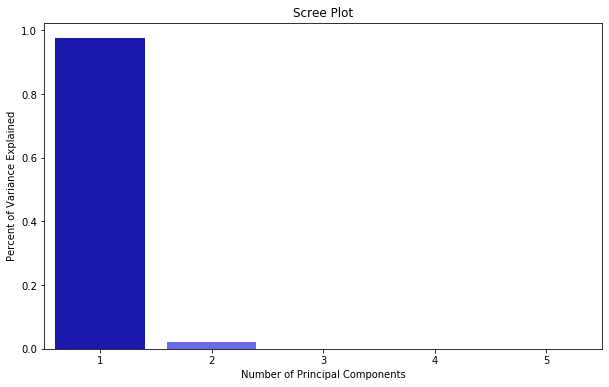

In [72]:
# Compute percent of variance explained
plt.figure(figsize=(10,6))
sns.barplot(pc, pve, palette='seismic')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Percent of Variance Explained');

From the plot above, we can see that PC1 alone is able to retain more than 95% of the percent of variance explained, which can be potentially beneficial if we include more data in our analysis.

In [34]:
# Get principal components
prcomp = PCA(numPC).fit_transform(X)

In [35]:
# Convert principal components into dataframe
col_name = ['isBankrupt'] + ['PC'+str(i+1) for i in range(numPC)]
PC_df = pd.DataFrame(np.insert(prcomp, 0, y, axis=1), columns=col_name)
PC_df.head()

isBankrupt         PC1        PC2        PC3       PC4       PC5
0         0.0 -104.620438 -48.272401  -0.334431 -2.059878 -2.928753
1         0.0  119.163248  14.950104  -1.958802  1.288093 -0.447651
2         0.0  -78.941353  11.167981   8.068005 -3.988459 -0.584148
3         0.0 -109.157234   1.002773  24.526657  3.589240  1.809017
4         0.0  -75.770841  19.480193   1.125071  0.275038 -1.202977

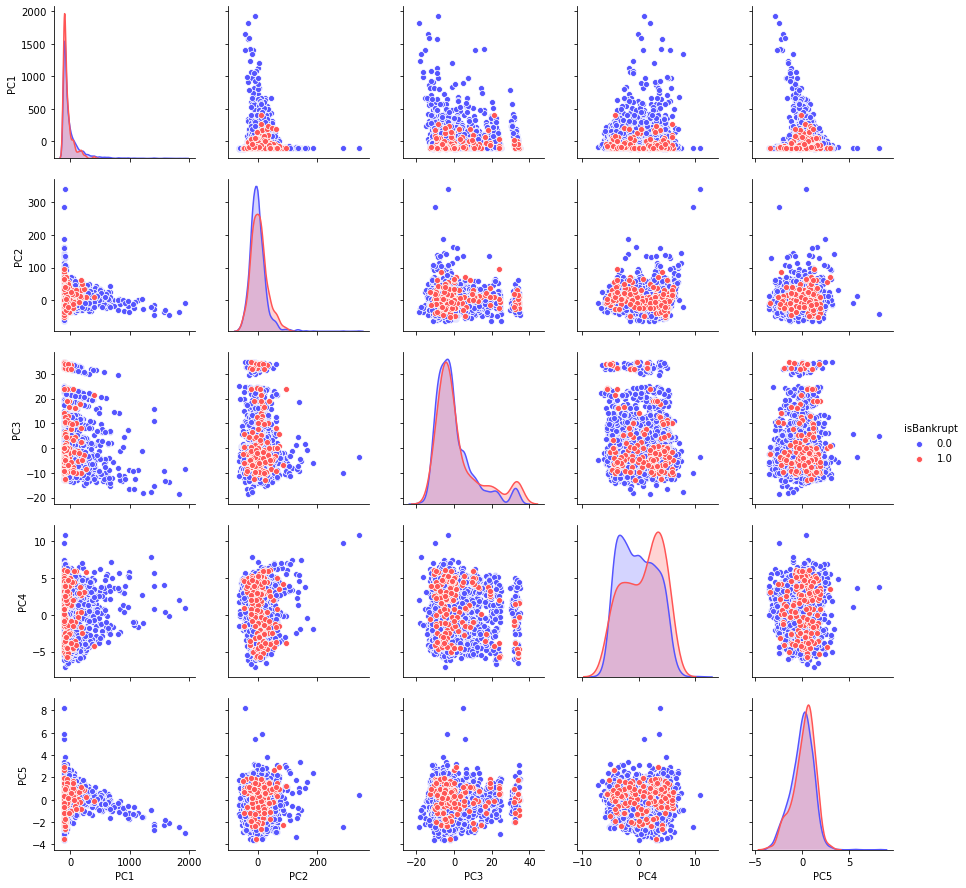

In [36]:
# Pairplot of 5 PCs
sns.pairplot(PC_df, hue='isBankrupt', vars=['PC'+str(i+1) for i in range(numPC)], palette='seismic');

- From the pairplot above, obviously PC1 explain the greatest amount of variance. 
- PC3 has an interesting distribution and it seems like it has some sort of invisible cutoff line which is visible and plot against other PCs.
- PC4 has a bimodal distribution for our isBankrupt label, which suggests that it can be potentially useful for making classification.

# 5. Classification

## 5.1 Train/Test Split

We will divde the data into 80% training and 20% test set.

In [37]:
# Divide data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=314)

In [38]:
# Check train data shape
X_train.shape, y_train.shape

((1994, 22), (1994,))

In [39]:
# Check test data shape
X_test.shape, y_test.shape

((499, 22), (499,))

## 5.2 Data Resampling

In [40]:
# Check class distribution of train data
y_train.value_counts()

0    1869
1     125
Name: isBankrupt, dtype: int64

In [41]:
# Check class distribution of test data
y_test.value_counts()

0    471
1     28
Name: isBankrupt, dtype: int64

As we can see from above, the `isBankrupt` label is highly unbalanced, which will cause our model to be biased. We will use `SMOTE` resampling method to oversample the minority class (in our case, `isBankrupt == 1`)

In [42]:
# Create synthetic data using SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [43]:
# Check resampled train data shape
X_res.shape, y_res.shape

((3738, 22), (3738,))

In [44]:
# Check class distribution of resampled data
pd.Series(y_res).value_counts()

1    1869
0    1869
dtype: int64

## 5.3 Logistic Regression

In [45]:
# Define a set of hyperparameters to cross validate
params = {'penalty':['l1','l2'], 
          'C':[0.001, 0.01, 0.1, 1, 10, 100], 
          'fit_intercept':[True], 
          'random_state':[314], 
          'solver':['liblinear'], 
          'n_jobs':[-1]}

In [46]:
# Convert dictionary into multiple combinations of hyperparameters
param_list = list(ParameterGrid(params))
len(param_list)

12

## 5.4 Cross Validation

In [47]:
# Perform cross validation
model = []
cv_score = []
for p in param_list:
    clf = LogisticRegression(**p)
    model.append(clf)
    cv_score.append(cross_val_score(clf, X_res, y_res, scoring='roc_auc', cv=10).mean())

In [48]:
# Get the best model
best_idx = cv_score.index(max(cv_score))
best_model = model[best_idx]
best_model

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l1', random_state=314, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

The result of cross validation suggests that the best model is with L1 penalty and cost 100. 

In [49]:
# Make preidction
best_model.fit(X_res, y_res)
y_pred = best_model.predict(X_test)

## 5.5 Confusion Matrix

In [50]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

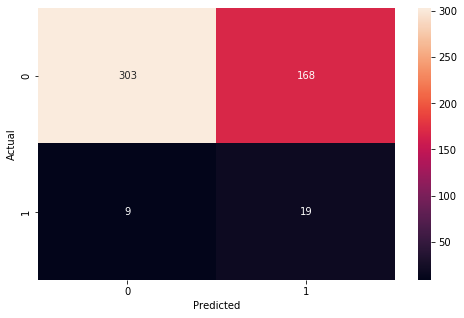

In [84]:
# Plot confusion matrix
plt.figure(figsize=(8,5))
sns.heatmap(cm, fmt='.4g', annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted');

- As we can see from the confusion matrix, the logistic regression is able to capture most of the restaurants that are not bankrupt, which results in a higher True Negative.

- However, only a few predictions that the model predicts as positive are actually positive. This results in a lower precision score.

- Since there are very few restaurants that are actually bankrupt, the model has a higher recall rate, which is not very surprising.

## 5.6 Performance Metrics

In [55]:
model_score = {
    'accuracy':accuracy_score(y_test, y_pred),
    'recall':recall_score(y_test, y_pred),
    'precision':precision_score(y_test, y_pred),
    'f1':f1_score(y_test, y_pred),
    'roc_auc':roc_auc_score(y_test, y_pred)
}

In [59]:
pd.DataFrame([model_score])

accuracy        f1  precision    recall   roc_auc
0  0.645291  0.176744   0.101604  0.678571  0.660942

## 5.7 Receiver Operating Characteristics

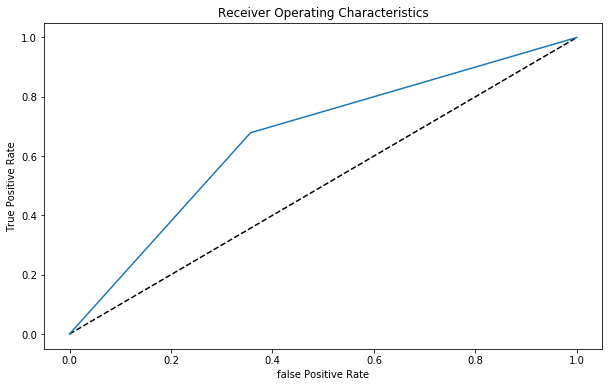

In [79]:
# Plot ROC curve
plt.figure(figsize=(10,6))
fpr, tpr, threshold = roc_curve(y_test, y_pred)
plt.plot([0,1], [0,1], 'k--')
sns.lineplot(fpr, tpr, palette='seismic')
plt.title('Receiver Operating Characteristics')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate');

The above ROC curve show that the model is doing better than chance, with area under the curve 0.66.

## 5.8 Model Interpretation

In [98]:
# Print the coefficient of the intercept
beta_0 = best_model.intercept_[0]
beta_0

0.633765213250407

In [99]:
# Probability when all variables are 0s
np.exp(beta_0) / (1 + np.exp(beta_0))

0.6533427219540918

The inverse log odds of the intercept indicates the default probability of being bankrupt within a year is 0.65, which implies that if a restaurant does totally nothing, it is possible that it becomes bankrupt in the next year. However, this interpretation is not realistic and practical but it does help us understand how the model explains the data.

In [95]:
lr_summary = pd.DataFrame(list(zip(X.columns, best_model.coef_[0])), columns=['variable', 'coefficient'])

In [106]:
lr_summary.sort_values('coefficient').reset_index(drop=True)

variable  coefficient
0               Price_Service   -85.590984
1   Coffee_Pastry_PortionSize    -9.827336
2                 star_rating    -1.308734
3                subjectivity    -1.134110
4                        cool    -0.823984
5                     isChain    -0.693038
6             Order_Wait_Time    -0.563511
7              restaurant_age    -0.115802
8                review_count    -0.004021
9               review_length     0.008686
10               neighborhood     0.026422
11      Breakfast_Description     0.199356
12                     useful     0.445850
13                      funny     0.547197
14                      stars     0.806901
15   Mexican_Food_Description     0.851612
16      Fast_Food_Description     1.061519
17          Dining_Experience     1.337208
18            Service_Quality     1.590546
19     Asian_Food_Description     2.534766
20                   polarity     2.579402
21           Gluten_Free_Food    22.386634

From the logistic regression summary above, we can see two extremes. One is `Price_Service`, which has the highest negative coefficient; the other is `Gluten_Free_Food` which has the highest positive coefficient.

Another important observation is that polarity has a positive coefficient, which can be a little counter-intuitive since restaurants are thought to have a higher probaility of bankruptcy if customers are unhappy. However, the model summary tells us otherwise, which is worth investigating.

One final comment about the model result is that most topic labels generally have higher coefficients, compared to other variables, which suggests that topic modeling is a very effective method in determining bankruptcy.